# Inicializace

In [4]:
from collections import deque                # Trida pro ukladani stavu
from __future__ import division              # Deleni realnych cisel (kvuli verzi Pythonu 2.6)

import numpy as np                           # Knihovna pro matematicke operace
import random                                # Knihovna pro nahodny vyber samplu z pameti
import sys                                   # Pro pripojeni knihovny Open AI Gym
sys.path.append('/home/xbucha02/libraries')  # Pripojeni knihovny Open AI Gym
import gym                                   # Knihovna Open AI Gym
#from gym import wrappers                    # Nahravani zaznamu
env = gym.make('MountainCar-v0')             # Konkretni hra z Open AI Gym
actionCount = env.action_space.n             # Pocet vstupu do prostredi
stateSize = env.observation_space.shape[0]   # Pocet vystupu z prostredi
#env = wrappers.Monitor(env, '/home/lachubcz/tmp/cartpole-experiment-1', force=True) #Nahravani zaznamu

#gpuMemoryUsage=1                            # Vyuziti pameti GPU
#import tensorflow as tf                     # Knihovna TensorFlow
#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = gpuMemoryUsage
#set_session(tf.Session(config=config))

# Parametry
observetime = 500                          # Delka pozorovani
episodes = 5000                            # Pocet epizod
games = 500                                # Pocet her
trainingAfterSucces = 100                  # Pocet trenovani na uspesnem datasetu
scores = []                                # Pole pro ulozeni vysledku na analyzu
episodesList = []                          # Pole pro ulozeni cisel epizod na analyzu
bestScore = 199                            # Promenna pro ukladani nejlepsiho prubezneho vysledku

# Agent

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics

class Agent:
    def __init__(self, env):
        self.startEpsilon = 1                           # Pravdepodobnost konani nahodneho tahu na zacatku
        self.endEpsilon = 0.01                          # Pravdepodobnost konani nahodneho tahu na konci
        self.currentEpsilon = self.startEpsilon         # Soucasna pravdepodobnost konani nahodneho tahu
        self.epsilonDiminution = 0.995                  # Hodnota snizovani epsilonu
        self.gamma = 0.99                               # Discount faktor
        self.minibatchSize = 32                         # Velikost minibatche
        self.actionCount = env.action_space.n           # Pocet vstupu do prostredi
        self.stateSize = env.observation_space.shape[0] # Pocet vystupu z prostredi
        self.learningRate = 0.005                       # Learning rate
        self.fractionUpdate = 0.125
        self.memorySize = 2000                          # Velikost Replay memory
        self.primaryMemory = deque(maxlen=self.memorySize)
        self.secondaryMemory = deque(maxlen=self.memorySize)
        
        self.net = self.getNN()
        self.netTarget = self.getNN()
        self.updateTargetNet()

    def getNN(self):
        net = Sequential()
        net.add(Dense(32, activation="relu", input_dim=self.stateSize))
        net.add(Dense(16, activation="relu"))
        net.add(Dense(self.actionCount, activation="linear"))

        net.summary()

        net.compile(loss=losses.mean_squared_error, optimizer=optimizers.Adam(lr=self.learningRate), metrics=['accuracy'])

        return net
    
    def updateTargetNet(self):
        self.netTarget.set_weights(self.net.get_weights())
    
    def updateTargetNetPartially(self):
        weights = self.net.get_weights()
        weightsTarget = self.netTarget.get_weights()
        
        for i in range(len(weightsTarget)):
            weightsTarget[i] = weights[i] * self.fractionUpdate + weightsTarget[i] * (1 - self.fractionUpdate)
            
        self.netTarget.set_weights(weightsTarget)
        
    def rememberPrimMem(self, state, action, reward, nextState, done):
        self.primaryMemory.append((state, action, reward, nextState, done))
    
    def rememberSecMem(self, state, action, reward, nextState, done):
        self.secondaryMemory.append((state, action, reward, nextState, done))
        
    def clearSecMem(self):
        self.secondaryMemory.clear()
        
    def epsilonActulization(self):
        if self.currentEpsilon > self.endEpsilon:
            if (self.currentEpsilon * self.epsilonDiminution) > self.endEpsilon:
                self.currentEpsilon = self.currentEpsilon * self.epsilonDiminution
            else:
                self.currentEpsilon = self.endEpsilon
    
    def getActionWE(self, state):
        if np.random.rand() <= self.currentEpsilon:
            return np.random.randint(0, self.actionCount, size=1)[0]
        else:
            Q = self.net.predict(state)
            return np.argmax(Q)

    def getAction(self, state):
        Q = self.net.predict(state)
        return np.argmax(Q)
    
    def resetSecMem(self):
        self.secondaryMemory = deque(maxlen=self.memorySize)
        
    def resetEpsilon(self):
        self.currentEpsilon = self.startEpsilon
    
    def trainDQN(self, typeOfMem):
        if typeOfMem == 1:
            if len(self.primaryMemory) >= self.minibatchSize:
                minibatch = random.sample(self.primaryMemory, self.minibatchSize)
            else:
                return
        elif typeOfMem == 2:
            if len(self.secondaryMemory) >= self.minibatchSize:
                minibatch = random.sample(self.secondaryMemory, self.minibatchSize)
            else:
                return
        else:
            return

        for i in range(0, self.minibatchSize):
            state = minibatch[i][0]
            action = minibatch[i][1]
            reward = minibatch[i][2]
            nextState = minibatch[i][3]
            done = minibatch[i][4]

            target_f = self.net.predict(state)

            if done:
                target_f[0][action] = reward
            else:
                aNet = self.net.predict(nextState)[0]

                target_f[0][action] = reward + self.gamma * np.max(aNet)

            self.net.fit(state, target_f, epochs=1, verbose=0)
                
    def trainDDQN(self, typeOfMem):
        if typeOfMem == 1:
            if len(self.primaryMemory) >= self.minibatchSize:
                minibatch = random.sample(self.primaryMemory, self.minibatchSize) #z D vybere pocet mb_size samplu
            else:
                return
        elif typeOfMem == 2:
            if len(self.secondaryMemory) >= self.minibatchSize:
                minibatch = random.sample(self.secondaryMemory, self.minibatchSize) #z D vybere pocet mb_size samplu
            else:
                return
        else:
            return

        for i in range(0, self.minibatchSize):
            state = minibatch[i][0]
            action = minibatch[i][1]
            reward = minibatch[i][2]
            nextState = minibatch[i][3]
            done = minibatch[i][4]

            target_f = self.net.predict(state)

            if done:
                target_f[0][action] = reward
            else:
                aNet = self.net.predict(nextState)[0]
                tNet = self.netTarget.predict(nextState)[0]
                target_f[0][action] = reward + self.gamma * tNet[np.argmax(aNet)]

            self.net.fit(state, target_f, epochs=10, verbose=0)
    
    def loadNN(self, name):
        self.net.load_weights(name)

    def saveNN(self, name):
        self.net.save_weights(name)

# Algoritmus

In [6]:
agent = Agent(env) #vytvoreni agenta
    
agent.loadNN("./DDQN-MountainCar-v0.h5") #nacteni NN
agent.updateTargetNet() #nacteni NN do netTarget

for eps in range (episodes):
    state = env.reset() #resetovani prostredi
    state = np.reshape(state, [1, stateSize]) #formatovani
    
    agent.epsilonActulization() #aktualizace epsilon
    
    #env.render()
    
    for t in range(observetime):
            
        action = agent.getActionWE(state) #ziskani akce

        newState, reward, done, info = env.step(action) #provedeni akce
        
        nextState = np.reshape(newState, [1, stateSize]) #formatovani

        agent.rememberPrimMem(state, action, reward, nextState, done) #ulozeni do primarni pameti
        agent.rememberPrimMem(state, action, reward, nextState, done) #ulozeni do sekundarni pameti
        
        #agent.trainDDQN(1) #trenovani na primarni pameti
        
        state = nextState #zmena stavu
        
        if done: #konec epizody
            print("Episode: {}/{}, epsilon: {:.2}, score: {}".format(eps, episodes, agent.currentEpsilon, t))
            
            scores.append(t) #ulozeni aktualniho skore
            episodesList.append(eps) #ulozeni aktualniho cisla epizody
            agent.trainDDQN(1)
            agent.updateTargetNet() #aktualizace target site
            
            if t < bestScore: #bylo dosazeno njelepsiho skore
                bestScore = t #nove nejlepsi skore
                for i in range(trainingAfterSucces): #pocet trenovani
                    agent.trainDDQN(2) #trenovani na sekundarni pameti
                agent.saveNN("./DDQN-MountainCar-v0-{}(1).h5" .format(eps)) #ulozeni site
                agent.resetEpsilon() #resetovani epsilonu
            
            agent.resetSecMem() #vycisteni sekundarni pameti
            
            break
            
agent.saveNN("./DDQN-MountainCar-v0(1).h5") #ulozeni site

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 51        
Total params: 675.0
Trainable params: 675
Non-trainable params: 0.0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12

Episode: 153/5000, epsilon: 0.46, score: 199
Episode: 154/5000, epsilon: 0.46, score: 199
Episode: 155/5000, epsilon: 0.46, score: 199
Episode: 156/5000, epsilon: 0.46, score: 199
Episode: 157/5000, epsilon: 0.45, score: 199
Episode: 158/5000, epsilon: 0.45, score: 199
Episode: 159/5000, epsilon: 0.45, score: 199
Episode: 160/5000, epsilon: 0.45, score: 199
Episode: 161/5000, epsilon: 0.44, score: 199
Episode: 162/5000, epsilon: 0.44, score: 199
Episode: 163/5000, epsilon: 0.44, score: 199
Episode: 164/5000, epsilon: 0.44, score: 199
Episode: 165/5000, epsilon: 0.44, score: 199
Episode: 166/5000, epsilon: 0.43, score: 199
Episode: 167/5000, epsilon: 0.43, score: 199
Episode: 168/5000, epsilon: 0.43, score: 199
Episode: 169/5000, epsilon: 0.43, score: 199
Episode: 170/5000, epsilon: 0.42, score: 199
Episode: 171/5000, epsilon: 0.42, score: 199
Episode: 172/5000, epsilon: 0.42, score: 199
Episode: 173/5000, epsilon: 0.42, score: 199
Episode: 174/5000, epsilon: 0.42, score: 199
Episode: 1

Episode: 336/5000, epsilon: 0.18, score: 199
Episode: 337/5000, epsilon: 0.18, score: 199
Episode: 338/5000, epsilon: 0.18, score: 199
Episode: 339/5000, epsilon: 0.18, score: 199
Episode: 340/5000, epsilon: 0.18, score: 199
Episode: 341/5000, epsilon: 0.18, score: 199
Episode: 342/5000, epsilon: 0.18, score: 199
Episode: 343/5000, epsilon: 0.18, score: 199
Episode: 344/5000, epsilon: 0.18, score: 199
Episode: 345/5000, epsilon: 0.18, score: 199
Episode: 346/5000, epsilon: 0.18, score: 199
Episode: 347/5000, epsilon: 0.17, score: 199
Episode: 348/5000, epsilon: 0.17, score: 199
Episode: 349/5000, epsilon: 0.17, score: 199
Episode: 350/5000, epsilon: 0.17, score: 199
Episode: 351/5000, epsilon: 0.17, score: 199
Episode: 352/5000, epsilon: 0.17, score: 199
Episode: 353/5000, epsilon: 0.17, score: 199
Episode: 354/5000, epsilon: 0.17, score: 199
Episode: 355/5000, epsilon: 0.17, score: 199
Episode: 356/5000, epsilon: 0.17, score: 199
Episode: 357/5000, epsilon: 0.17, score: 199
Episode: 3

Episode: 518/5000, epsilon: 0.074, score: 199
Episode: 519/5000, epsilon: 0.074, score: 199
Episode: 520/5000, epsilon: 0.073, score: 199
Episode: 521/5000, epsilon: 0.073, score: 199
Episode: 522/5000, epsilon: 0.073, score: 199
Episode: 523/5000, epsilon: 0.072, score: 199
Episode: 524/5000, epsilon: 0.072, score: 199
Episode: 525/5000, epsilon: 0.072, score: 199
Episode: 526/5000, epsilon: 0.071, score: 199
Episode: 527/5000, epsilon: 0.071, score: 199
Episode: 528/5000, epsilon: 0.071, score: 199
Episode: 529/5000, epsilon: 0.07, score: 199
Episode: 530/5000, epsilon: 0.07, score: 199
Episode: 531/5000, epsilon: 0.069, score: 199
Episode: 532/5000, epsilon: 0.069, score: 199
Episode: 533/5000, epsilon: 0.069, score: 199
Episode: 534/5000, epsilon: 0.068, score: 199
Episode: 535/5000, epsilon: 0.068, score: 199
Episode: 536/5000, epsilon: 0.068, score: 199
Episode: 537/5000, epsilon: 0.067, score: 199
Episode: 538/5000, epsilon: 0.067, score: 199
Episode: 539/5000, epsilon: 0.067, s

Episode: 697/5000, epsilon: 0.03, score: 199
Episode: 698/5000, epsilon: 0.03, score: 199
Episode: 699/5000, epsilon: 0.03, score: 199
Episode: 700/5000, epsilon: 0.03, score: 199
Episode: 701/5000, epsilon: 0.03, score: 199
Episode: 702/5000, epsilon: 0.029, score: 199
Episode: 703/5000, epsilon: 0.029, score: 199
Episode: 704/5000, epsilon: 0.029, score: 199
Episode: 705/5000, epsilon: 0.029, score: 199
Episode: 706/5000, epsilon: 0.029, score: 199
Episode: 707/5000, epsilon: 0.029, score: 199
Episode: 708/5000, epsilon: 0.029, score: 199
Episode: 709/5000, epsilon: 0.028, score: 199
Episode: 710/5000, epsilon: 0.028, score: 199
Episode: 711/5000, epsilon: 0.028, score: 199
Episode: 712/5000, epsilon: 0.028, score: 199
Episode: 713/5000, epsilon: 0.028, score: 199
Episode: 714/5000, epsilon: 0.028, score: 199
Episode: 715/5000, epsilon: 0.028, score: 199
Episode: 716/5000, epsilon: 0.027, score: 199
Episode: 717/5000, epsilon: 0.027, score: 199
Episode: 718/5000, epsilon: 0.027, scor

Episode: 876/5000, epsilon: 0.012, score: 199
Episode: 877/5000, epsilon: 0.012, score: 199
Episode: 878/5000, epsilon: 0.012, score: 199
Episode: 879/5000, epsilon: 0.012, score: 199
Episode: 880/5000, epsilon: 0.012, score: 199
Episode: 881/5000, epsilon: 0.012, score: 199
Episode: 882/5000, epsilon: 0.012, score: 199
Episode: 883/5000, epsilon: 0.012, score: 199
Episode: 884/5000, epsilon: 0.012, score: 199
Episode: 885/5000, epsilon: 0.012, score: 199
Episode: 886/5000, epsilon: 0.012, score: 199
Episode: 887/5000, epsilon: 0.012, score: 199
Episode: 888/5000, epsilon: 0.012, score: 199
Episode: 889/5000, epsilon: 0.012, score: 199
Episode: 890/5000, epsilon: 0.011, score: 199
Episode: 891/5000, epsilon: 0.011, score: 199
Episode: 892/5000, epsilon: 0.011, score: 199
Episode: 893/5000, epsilon: 0.011, score: 199
Episode: 894/5000, epsilon: 0.011, score: 199
Episode: 895/5000, epsilon: 0.011, score: 199
Episode: 896/5000, epsilon: 0.011, score: 199
Episode: 897/5000, epsilon: 0.011,

Episode: 1057/5000, epsilon: 0.01, score: 199
Episode: 1058/5000, epsilon: 0.01, score: 199
Episode: 1059/5000, epsilon: 0.01, score: 199
Episode: 1060/5000, epsilon: 0.01, score: 199
Episode: 1061/5000, epsilon: 0.01, score: 199
Episode: 1062/5000, epsilon: 0.01, score: 199
Episode: 1063/5000, epsilon: 0.01, score: 199
Episode: 1064/5000, epsilon: 0.01, score: 199
Episode: 1065/5000, epsilon: 0.01, score: 199
Episode: 1066/5000, epsilon: 0.01, score: 199
Episode: 1067/5000, epsilon: 0.01, score: 199
Episode: 1068/5000, epsilon: 0.01, score: 199
Episode: 1069/5000, epsilon: 0.01, score: 199
Episode: 1070/5000, epsilon: 0.01, score: 199
Episode: 1071/5000, epsilon: 0.01, score: 199
Episode: 1072/5000, epsilon: 0.01, score: 199
Episode: 1073/5000, epsilon: 0.01, score: 199
Episode: 1074/5000, epsilon: 0.01, score: 199
Episode: 1075/5000, epsilon: 0.01, score: 199
Episode: 1076/5000, epsilon: 0.01, score: 199
Episode: 1077/5000, epsilon: 0.01, score: 199
Episode: 1078/5000, epsilon: 0.01,

Episode: 1236/5000, epsilon: 0.01, score: 199
Episode: 1237/5000, epsilon: 0.01, score: 199
Episode: 1238/5000, epsilon: 0.01, score: 199
Episode: 1239/5000, epsilon: 0.01, score: 199
Episode: 1240/5000, epsilon: 0.01, score: 199
Episode: 1241/5000, epsilon: 0.01, score: 199
Episode: 1242/5000, epsilon: 0.01, score: 199
Episode: 1243/5000, epsilon: 0.01, score: 199
Episode: 1244/5000, epsilon: 0.01, score: 199
Episode: 1245/5000, epsilon: 0.01, score: 199
Episode: 1246/5000, epsilon: 0.01, score: 199
Episode: 1247/5000, epsilon: 0.01, score: 199
Episode: 1248/5000, epsilon: 0.01, score: 199
Episode: 1249/5000, epsilon: 0.01, score: 199
Episode: 1250/5000, epsilon: 0.01, score: 199
Episode: 1251/5000, epsilon: 0.01, score: 199
Episode: 1252/5000, epsilon: 0.01, score: 199
Episode: 1253/5000, epsilon: 0.01, score: 199
Episode: 1254/5000, epsilon: 0.01, score: 199
Episode: 1255/5000, epsilon: 0.01, score: 199
Episode: 1256/5000, epsilon: 0.01, score: 199
Episode: 1257/5000, epsilon: 0.01,

Episode: 1415/5000, epsilon: 0.01, score: 199
Episode: 1416/5000, epsilon: 0.01, score: 199
Episode: 1417/5000, epsilon: 0.01, score: 199
Episode: 1418/5000, epsilon: 0.01, score: 199
Episode: 1419/5000, epsilon: 0.01, score: 199
Episode: 1420/5000, epsilon: 0.01, score: 199
Episode: 1421/5000, epsilon: 0.01, score: 199
Episode: 1422/5000, epsilon: 0.01, score: 199
Episode: 1423/5000, epsilon: 0.01, score: 199
Episode: 1424/5000, epsilon: 0.01, score: 199
Episode: 1425/5000, epsilon: 0.01, score: 199
Episode: 1426/5000, epsilon: 0.01, score: 199
Episode: 1427/5000, epsilon: 0.01, score: 199
Episode: 1428/5000, epsilon: 0.01, score: 199
Episode: 1429/5000, epsilon: 0.01, score: 199
Episode: 1430/5000, epsilon: 0.01, score: 199
Episode: 1431/5000, epsilon: 0.01, score: 199
Episode: 1432/5000, epsilon: 0.01, score: 199
Episode: 1433/5000, epsilon: 0.01, score: 199
Episode: 1434/5000, epsilon: 0.01, score: 199
Episode: 1435/5000, epsilon: 0.01, score: 199
Episode: 1436/5000, epsilon: 0.01,

Episode: 1594/5000, epsilon: 0.01, score: 199
Episode: 1595/5000, epsilon: 0.01, score: 199
Episode: 1596/5000, epsilon: 0.01, score: 199
Episode: 1597/5000, epsilon: 0.01, score: 199
Episode: 1598/5000, epsilon: 0.01, score: 199
Episode: 1599/5000, epsilon: 0.01, score: 199
Episode: 1600/5000, epsilon: 0.01, score: 199
Episode: 1601/5000, epsilon: 0.01, score: 199
Episode: 1602/5000, epsilon: 0.01, score: 199
Episode: 1603/5000, epsilon: 0.01, score: 199
Episode: 1604/5000, epsilon: 0.01, score: 199
Episode: 1605/5000, epsilon: 0.01, score: 199
Episode: 1606/5000, epsilon: 0.01, score: 199
Episode: 1607/5000, epsilon: 0.01, score: 199
Episode: 1608/5000, epsilon: 0.01, score: 199
Episode: 1609/5000, epsilon: 0.01, score: 199
Episode: 1610/5000, epsilon: 0.01, score: 199
Episode: 1611/5000, epsilon: 0.01, score: 199
Episode: 1612/5000, epsilon: 0.01, score: 199
Episode: 1613/5000, epsilon: 0.01, score: 199
Episode: 1614/5000, epsilon: 0.01, score: 199
Episode: 1615/5000, epsilon: 0.01,

Episode: 1773/5000, epsilon: 0.01, score: 199
Episode: 1774/5000, epsilon: 0.01, score: 199
Episode: 1775/5000, epsilon: 0.01, score: 199
Episode: 1776/5000, epsilon: 0.01, score: 199
Episode: 1777/5000, epsilon: 0.01, score: 199
Episode: 1778/5000, epsilon: 0.01, score: 199
Episode: 1779/5000, epsilon: 0.01, score: 199
Episode: 1780/5000, epsilon: 0.01, score: 199
Episode: 1781/5000, epsilon: 0.01, score: 199
Episode: 1782/5000, epsilon: 0.01, score: 199
Episode: 1783/5000, epsilon: 0.01, score: 199
Episode: 1784/5000, epsilon: 0.01, score: 199
Episode: 1785/5000, epsilon: 0.01, score: 199
Episode: 1786/5000, epsilon: 0.01, score: 199
Episode: 1787/5000, epsilon: 0.01, score: 199
Episode: 1788/5000, epsilon: 0.01, score: 199
Episode: 1789/5000, epsilon: 0.01, score: 199
Episode: 1790/5000, epsilon: 0.01, score: 199
Episode: 1791/5000, epsilon: 0.01, score: 199
Episode: 1792/5000, epsilon: 0.01, score: 199
Episode: 1793/5000, epsilon: 0.01, score: 199
Episode: 1794/5000, epsilon: 0.01,

Episode: 1952/5000, epsilon: 0.01, score: 199
Episode: 1953/5000, epsilon: 0.01, score: 199
Episode: 1954/5000, epsilon: 0.01, score: 199
Episode: 1955/5000, epsilon: 0.01, score: 199
Episode: 1956/5000, epsilon: 0.01, score: 199
Episode: 1957/5000, epsilon: 0.01, score: 199
Episode: 1958/5000, epsilon: 0.01, score: 199
Episode: 1959/5000, epsilon: 0.01, score: 199
Episode: 1960/5000, epsilon: 0.01, score: 199
Episode: 1961/5000, epsilon: 0.01, score: 199
Episode: 1962/5000, epsilon: 0.01, score: 199
Episode: 1963/5000, epsilon: 0.01, score: 199
Episode: 1964/5000, epsilon: 0.01, score: 199
Episode: 1965/5000, epsilon: 0.01, score: 199
Episode: 1966/5000, epsilon: 0.01, score: 199
Episode: 1967/5000, epsilon: 0.01, score: 199
Episode: 1968/5000, epsilon: 0.01, score: 199
Episode: 1969/5000, epsilon: 0.01, score: 199
Episode: 1970/5000, epsilon: 0.01, score: 199
Episode: 1971/5000, epsilon: 0.01, score: 199
Episode: 1972/5000, epsilon: 0.01, score: 199
Episode: 1973/5000, epsilon: 0.01,

Episode: 2131/5000, epsilon: 0.01, score: 199
Episode: 2132/5000, epsilon: 0.01, score: 199
Episode: 2133/5000, epsilon: 0.01, score: 199
Episode: 2134/5000, epsilon: 0.01, score: 199
Episode: 2135/5000, epsilon: 0.01, score: 199
Episode: 2136/5000, epsilon: 0.01, score: 199
Episode: 2137/5000, epsilon: 0.01, score: 199
Episode: 2138/5000, epsilon: 0.01, score: 199
Episode: 2139/5000, epsilon: 0.01, score: 199
Episode: 2140/5000, epsilon: 0.01, score: 199
Episode: 2141/5000, epsilon: 0.01, score: 199
Episode: 2142/5000, epsilon: 0.01, score: 199
Episode: 2143/5000, epsilon: 0.01, score: 199
Episode: 2144/5000, epsilon: 0.01, score: 199
Episode: 2145/5000, epsilon: 0.01, score: 199
Episode: 2146/5000, epsilon: 0.01, score: 199
Episode: 2147/5000, epsilon: 0.01, score: 199
Episode: 2148/5000, epsilon: 0.01, score: 199
Episode: 2149/5000, epsilon: 0.01, score: 199
Episode: 2150/5000, epsilon: 0.01, score: 199
Episode: 2151/5000, epsilon: 0.01, score: 199
Episode: 2152/5000, epsilon: 0.01,

Episode: 2310/5000, epsilon: 0.01, score: 199
Episode: 2311/5000, epsilon: 0.01, score: 199
Episode: 2312/5000, epsilon: 0.01, score: 199
Episode: 2313/5000, epsilon: 0.01, score: 199
Episode: 2314/5000, epsilon: 0.01, score: 199
Episode: 2315/5000, epsilon: 0.01, score: 199
Episode: 2316/5000, epsilon: 0.01, score: 199
Episode: 2317/5000, epsilon: 0.01, score: 199
Episode: 2318/5000, epsilon: 0.01, score: 199
Episode: 2319/5000, epsilon: 0.01, score: 199
Episode: 2320/5000, epsilon: 0.01, score: 199
Episode: 2321/5000, epsilon: 0.01, score: 199
Episode: 2322/5000, epsilon: 0.01, score: 199
Episode: 2323/5000, epsilon: 0.01, score: 199
Episode: 2324/5000, epsilon: 0.01, score: 199
Episode: 2325/5000, epsilon: 0.01, score: 199
Episode: 2326/5000, epsilon: 0.01, score: 199
Episode: 2327/5000, epsilon: 0.01, score: 199
Episode: 2328/5000, epsilon: 0.01, score: 199
Episode: 2329/5000, epsilon: 0.01, score: 199
Episode: 2330/5000, epsilon: 0.01, score: 199
Episode: 2331/5000, epsilon: 0.01,

Episode: 2489/5000, epsilon: 0.01, score: 199
Episode: 2490/5000, epsilon: 0.01, score: 199
Episode: 2491/5000, epsilon: 0.01, score: 199
Episode: 2492/5000, epsilon: 0.01, score: 199
Episode: 2493/5000, epsilon: 0.01, score: 199
Episode: 2494/5000, epsilon: 0.01, score: 199
Episode: 2495/5000, epsilon: 0.01, score: 199
Episode: 2496/5000, epsilon: 0.01, score: 199
Episode: 2497/5000, epsilon: 0.01, score: 199
Episode: 2498/5000, epsilon: 0.01, score: 199
Episode: 2499/5000, epsilon: 0.01, score: 199
Episode: 2500/5000, epsilon: 0.01, score: 199
Episode: 2501/5000, epsilon: 0.01, score: 199
Episode: 2502/5000, epsilon: 0.01, score: 199
Episode: 2503/5000, epsilon: 0.01, score: 199
Episode: 2504/5000, epsilon: 0.01, score: 199
Episode: 2505/5000, epsilon: 0.01, score: 199
Episode: 2506/5000, epsilon: 0.01, score: 199
Episode: 2507/5000, epsilon: 0.01, score: 199
Episode: 2508/5000, epsilon: 0.01, score: 199
Episode: 2509/5000, epsilon: 0.01, score: 199
Episode: 2510/5000, epsilon: 0.01,

Episode: 2668/5000, epsilon: 0.01, score: 199
Episode: 2669/5000, epsilon: 0.01, score: 199
Episode: 2670/5000, epsilon: 0.01, score: 199
Episode: 2671/5000, epsilon: 0.01, score: 199
Episode: 2672/5000, epsilon: 0.01, score: 199
Episode: 2673/5000, epsilon: 0.01, score: 199
Episode: 2674/5000, epsilon: 0.01, score: 199
Episode: 2675/5000, epsilon: 0.01, score: 199
Episode: 2676/5000, epsilon: 0.01, score: 199
Episode: 2677/5000, epsilon: 0.01, score: 199
Episode: 2678/5000, epsilon: 0.01, score: 199
Episode: 2679/5000, epsilon: 0.01, score: 199
Episode: 2680/5000, epsilon: 0.01, score: 199
Episode: 2681/5000, epsilon: 0.01, score: 199
Episode: 2682/5000, epsilon: 0.01, score: 199
Episode: 2683/5000, epsilon: 0.01, score: 199
Episode: 2684/5000, epsilon: 0.01, score: 199
Episode: 2685/5000, epsilon: 0.01, score: 199
Episode: 2686/5000, epsilon: 0.01, score: 199
Episode: 2687/5000, epsilon: 0.01, score: 199
Episode: 2688/5000, epsilon: 0.01, score: 199
Episode: 2689/5000, epsilon: 0.01,

Episode: 2847/5000, epsilon: 0.01, score: 199
Episode: 2848/5000, epsilon: 0.01, score: 199
Episode: 2849/5000, epsilon: 0.01, score: 199
Episode: 2850/5000, epsilon: 0.01, score: 199
Episode: 2851/5000, epsilon: 0.01, score: 199
Episode: 2852/5000, epsilon: 0.01, score: 199
Episode: 2853/5000, epsilon: 0.01, score: 199
Episode: 2854/5000, epsilon: 0.01, score: 199
Episode: 2855/5000, epsilon: 0.01, score: 199
Episode: 2856/5000, epsilon: 0.01, score: 199
Episode: 2857/5000, epsilon: 0.01, score: 199
Episode: 2858/5000, epsilon: 0.01, score: 199
Episode: 2859/5000, epsilon: 0.01, score: 199
Episode: 2860/5000, epsilon: 0.01, score: 199
Episode: 2861/5000, epsilon: 0.01, score: 199
Episode: 2862/5000, epsilon: 0.01, score: 199
Episode: 2863/5000, epsilon: 0.01, score: 199
Episode: 2864/5000, epsilon: 0.01, score: 199
Episode: 2865/5000, epsilon: 0.01, score: 199
Episode: 2866/5000, epsilon: 0.01, score: 199
Episode: 2867/5000, epsilon: 0.01, score: 199
Episode: 2868/5000, epsilon: 0.01,

Episode: 3026/5000, epsilon: 0.01, score: 199
Episode: 3027/5000, epsilon: 0.01, score: 199
Episode: 3028/5000, epsilon: 0.01, score: 199
Episode: 3029/5000, epsilon: 0.01, score: 199
Episode: 3030/5000, epsilon: 0.01, score: 199
Episode: 3031/5000, epsilon: 0.01, score: 199
Episode: 3032/5000, epsilon: 0.01, score: 199
Episode: 3033/5000, epsilon: 0.01, score: 199
Episode: 3034/5000, epsilon: 0.01, score: 199
Episode: 3035/5000, epsilon: 0.01, score: 199
Episode: 3036/5000, epsilon: 0.01, score: 199
Episode: 3037/5000, epsilon: 0.01, score: 199
Episode: 3038/5000, epsilon: 0.01, score: 199
Episode: 3039/5000, epsilon: 0.01, score: 199
Episode: 3040/5000, epsilon: 0.01, score: 199
Episode: 3041/5000, epsilon: 0.01, score: 199
Episode: 3042/5000, epsilon: 0.01, score: 199
Episode: 3043/5000, epsilon: 0.01, score: 199
Episode: 3044/5000, epsilon: 0.01, score: 199
Episode: 3045/5000, epsilon: 0.01, score: 199
Episode: 3046/5000, epsilon: 0.01, score: 199
Episode: 3047/5000, epsilon: 0.01,

Episode: 3205/5000, epsilon: 0.01, score: 199
Episode: 3206/5000, epsilon: 0.01, score: 199
Episode: 3207/5000, epsilon: 0.01, score: 199
Episode: 3208/5000, epsilon: 0.01, score: 199
Episode: 3209/5000, epsilon: 0.01, score: 199
Episode: 3210/5000, epsilon: 0.01, score: 199
Episode: 3211/5000, epsilon: 0.01, score: 199
Episode: 3212/5000, epsilon: 0.01, score: 199
Episode: 3213/5000, epsilon: 0.01, score: 199
Episode: 3214/5000, epsilon: 0.01, score: 199
Episode: 3215/5000, epsilon: 0.01, score: 199
Episode: 3216/5000, epsilon: 0.01, score: 199
Episode: 3217/5000, epsilon: 0.01, score: 199
Episode: 3218/5000, epsilon: 0.01, score: 199
Episode: 3219/5000, epsilon: 0.01, score: 199
Episode: 3220/5000, epsilon: 0.01, score: 199
Episode: 3221/5000, epsilon: 0.01, score: 199
Episode: 3222/5000, epsilon: 0.01, score: 199
Episode: 3223/5000, epsilon: 0.01, score: 199
Episode: 3224/5000, epsilon: 0.01, score: 199
Episode: 3225/5000, epsilon: 0.01, score: 199
Episode: 3226/5000, epsilon: 0.01,

Episode: 3384/5000, epsilon: 0.01, score: 199
Episode: 3385/5000, epsilon: 0.01, score: 199
Episode: 3386/5000, epsilon: 0.01, score: 199
Episode: 3387/5000, epsilon: 0.01, score: 199
Episode: 3388/5000, epsilon: 0.01, score: 199
Episode: 3389/5000, epsilon: 0.01, score: 199
Episode: 3390/5000, epsilon: 0.01, score: 199
Episode: 3391/5000, epsilon: 0.01, score: 199
Episode: 3392/5000, epsilon: 0.01, score: 199
Episode: 3393/5000, epsilon: 0.01, score: 199
Episode: 3394/5000, epsilon: 0.01, score: 199
Episode: 3395/5000, epsilon: 0.01, score: 199
Episode: 3396/5000, epsilon: 0.01, score: 199
Episode: 3397/5000, epsilon: 0.01, score: 199
Episode: 3398/5000, epsilon: 0.01, score: 199
Episode: 3399/5000, epsilon: 0.01, score: 199
Episode: 3400/5000, epsilon: 0.01, score: 199
Episode: 3401/5000, epsilon: 0.01, score: 199
Episode: 3402/5000, epsilon: 0.01, score: 199
Episode: 3403/5000, epsilon: 0.01, score: 199
Episode: 3404/5000, epsilon: 0.01, score: 199
Episode: 3405/5000, epsilon: 0.01,

Episode: 3563/5000, epsilon: 0.01, score: 199
Episode: 3564/5000, epsilon: 0.01, score: 199
Episode: 3565/5000, epsilon: 0.01, score: 199
Episode: 3566/5000, epsilon: 0.01, score: 199
Episode: 3567/5000, epsilon: 0.01, score: 199
Episode: 3568/5000, epsilon: 0.01, score: 199
Episode: 3569/5000, epsilon: 0.01, score: 199
Episode: 3570/5000, epsilon: 0.01, score: 199
Episode: 3571/5000, epsilon: 0.01, score: 199
Episode: 3572/5000, epsilon: 0.01, score: 199
Episode: 3573/5000, epsilon: 0.01, score: 199
Episode: 3574/5000, epsilon: 0.01, score: 199
Episode: 3575/5000, epsilon: 0.01, score: 199
Episode: 3576/5000, epsilon: 0.01, score: 199
Episode: 3577/5000, epsilon: 0.01, score: 199
Episode: 3578/5000, epsilon: 0.01, score: 199
Episode: 3579/5000, epsilon: 0.01, score: 199
Episode: 3580/5000, epsilon: 0.01, score: 199
Episode: 3581/5000, epsilon: 0.01, score: 199
Episode: 3582/5000, epsilon: 0.01, score: 199
Episode: 3583/5000, epsilon: 0.01, score: 199
Episode: 3584/5000, epsilon: 0.01,

Episode: 3742/5000, epsilon: 0.01, score: 199
Episode: 3743/5000, epsilon: 0.01, score: 199
Episode: 3744/5000, epsilon: 0.01, score: 199
Episode: 3745/5000, epsilon: 0.01, score: 199
Episode: 3746/5000, epsilon: 0.01, score: 199
Episode: 3747/5000, epsilon: 0.01, score: 199
Episode: 3748/5000, epsilon: 0.01, score: 199
Episode: 3749/5000, epsilon: 0.01, score: 199
Episode: 3750/5000, epsilon: 0.01, score: 199
Episode: 3751/5000, epsilon: 0.01, score: 199
Episode: 3752/5000, epsilon: 0.01, score: 199
Episode: 3753/5000, epsilon: 0.01, score: 199
Episode: 3754/5000, epsilon: 0.01, score: 199
Episode: 3755/5000, epsilon: 0.01, score: 199
Episode: 3756/5000, epsilon: 0.01, score: 199
Episode: 3757/5000, epsilon: 0.01, score: 199
Episode: 3758/5000, epsilon: 0.01, score: 199
Episode: 3759/5000, epsilon: 0.01, score: 199
Episode: 3760/5000, epsilon: 0.01, score: 199
Episode: 3761/5000, epsilon: 0.01, score: 199
Episode: 3762/5000, epsilon: 0.01, score: 199
Episode: 3763/5000, epsilon: 0.01,

Episode: 3921/5000, epsilon: 0.01, score: 199
Episode: 3922/5000, epsilon: 0.01, score: 199
Episode: 3923/5000, epsilon: 0.01, score: 199
Episode: 3924/5000, epsilon: 0.01, score: 199
Episode: 3925/5000, epsilon: 0.01, score: 199
Episode: 3926/5000, epsilon: 0.01, score: 199
Episode: 3927/5000, epsilon: 0.01, score: 199
Episode: 3928/5000, epsilon: 0.01, score: 199
Episode: 3929/5000, epsilon: 0.01, score: 199
Episode: 3930/5000, epsilon: 0.01, score: 199
Episode: 3931/5000, epsilon: 0.01, score: 199
Episode: 3932/5000, epsilon: 0.01, score: 199
Episode: 3933/5000, epsilon: 0.01, score: 199
Episode: 3934/5000, epsilon: 0.01, score: 199
Episode: 3935/5000, epsilon: 0.01, score: 199
Episode: 3936/5000, epsilon: 0.01, score: 199
Episode: 3937/5000, epsilon: 0.01, score: 199
Episode: 3938/5000, epsilon: 0.01, score: 199
Episode: 3939/5000, epsilon: 0.01, score: 199
Episode: 3940/5000, epsilon: 0.01, score: 199
Episode: 3941/5000, epsilon: 0.01, score: 199
Episode: 3942/5000, epsilon: 0.01,

Episode: 4100/5000, epsilon: 0.01, score: 199
Episode: 4101/5000, epsilon: 0.01, score: 199
Episode: 4102/5000, epsilon: 0.01, score: 199
Episode: 4103/5000, epsilon: 0.01, score: 199
Episode: 4104/5000, epsilon: 0.01, score: 199
Episode: 4105/5000, epsilon: 0.01, score: 199
Episode: 4106/5000, epsilon: 0.01, score: 199
Episode: 4107/5000, epsilon: 0.01, score: 199
Episode: 4108/5000, epsilon: 0.01, score: 199
Episode: 4109/5000, epsilon: 0.01, score: 199
Episode: 4110/5000, epsilon: 0.01, score: 199
Episode: 4111/5000, epsilon: 0.01, score: 199
Episode: 4112/5000, epsilon: 0.01, score: 199
Episode: 4113/5000, epsilon: 0.01, score: 199
Episode: 4114/5000, epsilon: 0.01, score: 199
Episode: 4115/5000, epsilon: 0.01, score: 199
Episode: 4116/5000, epsilon: 0.01, score: 199
Episode: 4117/5000, epsilon: 0.01, score: 199
Episode: 4118/5000, epsilon: 0.01, score: 199
Episode: 4119/5000, epsilon: 0.01, score: 199
Episode: 4120/5000, epsilon: 0.01, score: 199
Episode: 4121/5000, epsilon: 0.01,

Episode: 4279/5000, epsilon: 0.01, score: 199
Episode: 4280/5000, epsilon: 0.01, score: 199
Episode: 4281/5000, epsilon: 0.01, score: 199
Episode: 4282/5000, epsilon: 0.01, score: 199
Episode: 4283/5000, epsilon: 0.01, score: 199
Episode: 4284/5000, epsilon: 0.01, score: 199
Episode: 4285/5000, epsilon: 0.01, score: 199
Episode: 4286/5000, epsilon: 0.01, score: 199
Episode: 4287/5000, epsilon: 0.01, score: 199
Episode: 4288/5000, epsilon: 0.01, score: 199
Episode: 4289/5000, epsilon: 0.01, score: 199
Episode: 4290/5000, epsilon: 0.01, score: 199
Episode: 4291/5000, epsilon: 0.01, score: 199
Episode: 4292/5000, epsilon: 0.01, score: 199
Episode: 4293/5000, epsilon: 0.01, score: 199
Episode: 4294/5000, epsilon: 0.01, score: 199
Episode: 4295/5000, epsilon: 0.01, score: 199
Episode: 4296/5000, epsilon: 0.01, score: 199
Episode: 4297/5000, epsilon: 0.01, score: 199
Episode: 4298/5000, epsilon: 0.01, score: 199
Episode: 4299/5000, epsilon: 0.01, score: 199
Episode: 4300/5000, epsilon: 0.01,

Episode: 4458/5000, epsilon: 0.01, score: 199
Episode: 4459/5000, epsilon: 0.01, score: 199
Episode: 4460/5000, epsilon: 0.01, score: 199
Episode: 4461/5000, epsilon: 0.01, score: 199
Episode: 4462/5000, epsilon: 0.01, score: 199
Episode: 4463/5000, epsilon: 0.01, score: 199
Episode: 4464/5000, epsilon: 0.01, score: 199
Episode: 4465/5000, epsilon: 0.01, score: 199
Episode: 4466/5000, epsilon: 0.01, score: 199
Episode: 4467/5000, epsilon: 0.01, score: 199
Episode: 4468/5000, epsilon: 0.01, score: 199
Episode: 4469/5000, epsilon: 0.01, score: 199
Episode: 4470/5000, epsilon: 0.01, score: 199
Episode: 4471/5000, epsilon: 0.01, score: 199
Episode: 4472/5000, epsilon: 0.01, score: 199
Episode: 4473/5000, epsilon: 0.01, score: 199
Episode: 4474/5000, epsilon: 0.01, score: 199
Episode: 4475/5000, epsilon: 0.01, score: 199
Episode: 4476/5000, epsilon: 0.01, score: 199
Episode: 4477/5000, epsilon: 0.01, score: 199
Episode: 4478/5000, epsilon: 0.01, score: 199
Episode: 4479/5000, epsilon: 0.01,

Episode: 4637/5000, epsilon: 0.01, score: 199
Episode: 4638/5000, epsilon: 0.01, score: 199
Episode: 4639/5000, epsilon: 0.01, score: 199
Episode: 4640/5000, epsilon: 0.01, score: 199
Episode: 4641/5000, epsilon: 0.01, score: 199
Episode: 4642/5000, epsilon: 0.01, score: 199
Episode: 4643/5000, epsilon: 0.01, score: 199
Episode: 4644/5000, epsilon: 0.01, score: 199
Episode: 4645/5000, epsilon: 0.01, score: 199
Episode: 4646/5000, epsilon: 0.01, score: 199
Episode: 4647/5000, epsilon: 0.01, score: 199
Episode: 4648/5000, epsilon: 0.01, score: 199
Episode: 4649/5000, epsilon: 0.01, score: 199
Episode: 4650/5000, epsilon: 0.01, score: 199
Episode: 4651/5000, epsilon: 0.01, score: 199
Episode: 4652/5000, epsilon: 0.01, score: 199
Episode: 4653/5000, epsilon: 0.01, score: 199
Episode: 4654/5000, epsilon: 0.01, score: 199
Episode: 4655/5000, epsilon: 0.01, score: 199
Episode: 4656/5000, epsilon: 0.01, score: 199
Episode: 4657/5000, epsilon: 0.01, score: 199
Episode: 4658/5000, epsilon: 0.01,

Episode: 4816/5000, epsilon: 0.01, score: 199
Episode: 4817/5000, epsilon: 0.01, score: 199
Episode: 4818/5000, epsilon: 0.01, score: 199
Episode: 4819/5000, epsilon: 0.01, score: 199
Episode: 4820/5000, epsilon: 0.01, score: 199
Episode: 4821/5000, epsilon: 0.01, score: 199
Episode: 4822/5000, epsilon: 0.01, score: 199
Episode: 4823/5000, epsilon: 0.01, score: 199
Episode: 4824/5000, epsilon: 0.01, score: 199
Episode: 4825/5000, epsilon: 0.01, score: 199
Episode: 4826/5000, epsilon: 0.01, score: 199
Episode: 4827/5000, epsilon: 0.01, score: 199
Episode: 4828/5000, epsilon: 0.01, score: 199
Episode: 4829/5000, epsilon: 0.01, score: 199
Episode: 4830/5000, epsilon: 0.01, score: 199
Episode: 4831/5000, epsilon: 0.01, score: 199
Episode: 4832/5000, epsilon: 0.01, score: 199
Episode: 4833/5000, epsilon: 0.01, score: 199
Episode: 4834/5000, epsilon: 0.01, score: 199
Episode: 4835/5000, epsilon: 0.01, score: 199
Episode: 4836/5000, epsilon: 0.01, score: 199
Episode: 4837/5000, epsilon: 0.01,

Episode: 4995/5000, epsilon: 0.01, score: 199
Episode: 4996/5000, epsilon: 0.01, score: 199
Episode: 4997/5000, epsilon: 0.01, score: 199
Episode: 4998/5000, epsilon: 0.01, score: 199
Episode: 4999/5000, epsilon: 0.01, score: 199


# Výsledky

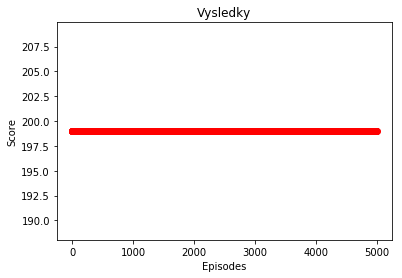

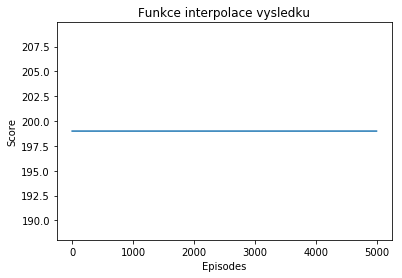

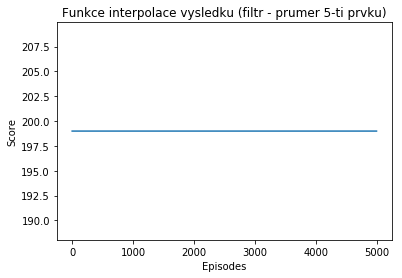

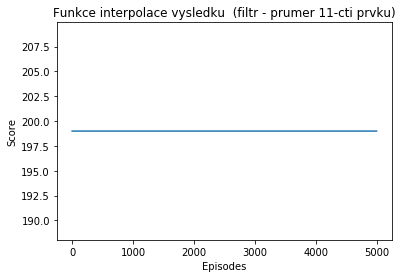

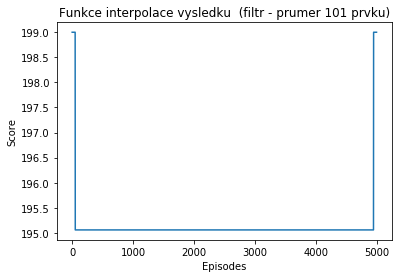

In [7]:
%matplotlib inline  
import matplotlib.pyplot as plt
import copy

def analysis(scores, episodesList):
    score1 = copy.copy(scores)
    score2 = copy.copy(scores)
    score3 = copy.copy(scores)

    for i in range (len(scores)):
        if i > 1 and i < (len(scores)-2):
            score1[i] = (scores[i - 2] + scores[i - 1] + scores[i] + scores[i + 1] + scores[i + 2])/5

    for i in range (len(scores)):
        if i > 4 and i < (len(scores)-5):
            score2[i] += scores[i - 5] + scores[i - 4] + scores[i - 3] + scores[i - 2] + scores[i - 1]
            score2[i] += scores[i + 5] + scores[i + 4] + scores[i + 3] + scores[i + 2] + scores[i + 1]
            score2[i] = score2[i]/11

    for i in range (len(scores)):
        if i > 49 and i < (len(scores) - 50):
            for e in range (1,50):
                score3[i] += scores[i - e] + scores[i + e] 
            score3[i] = score3[i]/101      

    plt.plot(episodesList, scores, 'ro')
    plt.ylabel("Score")
    plt.xlabel("Episodes")
    plt.title("Vysledky")
    plt.show()

    plt.plot(scores)
    plt.ylabel("Score")
    plt.xlabel("Episodes")
    plt.title("Funkce interpolace vysledku")
    plt.show()

    plt.plot(score1)
    plt.ylabel("Score")
    plt.xlabel("Episodes")
    plt.title("Funkce interpolace vysledku (filtr - prumer 5-ti prvku)")
    plt.show()

    plt.plot(score2)
    plt.ylabel("Score")
    plt.xlabel("Episodes")
    plt.title("Funkce interpolace vysledku  (filtr - prumer 11-cti prvku)")
    plt.show()

    plt.plot(score3)
    plt.ylabel("Score")
    plt.xlabel("Episodes")
    plt.title("Funkce interpolace vysledku  (filtr - prumer 101 prvku)")
    plt.show()
    
analysis(scores, episodesList)

# Hra

Game 0/500, score: -200.0
Game 1/500, score: -200.0
Game 2/500, score: -200.0
Game 3/500, score: -200.0
Game 4/500, score: -200.0
Game 5/500, score: -200.0
Game 6/500, score: -200.0
Game 7/500, score: -200.0
Game 8/500, score: -200.0
Game 9/500, score: -200.0
Game 10/500, score: -200.0
Game 11/500, score: -200.0
Game 12/500, score: -200.0
Game 13/500, score: -200.0
Game 14/500, score: -200.0
Game 15/500, score: -200.0
Game 16/500, score: -200.0
Game 17/500, score: -200.0
Game 18/500, score: -200.0
Game 19/500, score: -200.0
Game 20/500, score: -200.0
Game 21/500, score: -200.0
Game 22/500, score: -200.0
Game 23/500, score: -200.0
Game 24/500, score: -200.0
Game 25/500, score: -200.0
Game 26/500, score: -200.0
Game 27/500, score: -200.0
Game 28/500, score: -200.0
Game 29/500, score: -200.0
Game 30/500, score: -200.0
Game 31/500, score: -200.0
Game 32/500, score: -200.0
Game 33/500, score: -200.0
Game 34/500, score: -200.0
Game 35/500, score: -200.0
Game 36/500, score: -200.0
Game 37/500

Game 297/500, score: -200.0
Game 298/500, score: -200.0
Game 299/500, score: -200.0
Game 300/500, score: -200.0
Game 301/500, score: -200.0
Game 302/500, score: -200.0
Game 303/500, score: -200.0
Game 304/500, score: -200.0
Game 305/500, score: -200.0
Game 306/500, score: -200.0
Game 307/500, score: -200.0
Game 308/500, score: -200.0
Game 309/500, score: -200.0
Game 310/500, score: -200.0
Game 311/500, score: -200.0
Game 312/500, score: -200.0
Game 313/500, score: -200.0
Game 314/500, score: -200.0
Game 315/500, score: -200.0
Game 316/500, score: -200.0
Game 317/500, score: -200.0
Game 318/500, score: -200.0
Game 319/500, score: -200.0
Game 320/500, score: -200.0
Game 321/500, score: -200.0
Game 322/500, score: -200.0
Game 323/500, score: -200.0
Game 324/500, score: -200.0
Game 325/500, score: -200.0
Game 326/500, score: -200.0
Game 327/500, score: -200.0
Game 328/500, score: -200.0
Game 329/500, score: -200.0
Game 330/500, score: -200.0
Game 331/500, score: -200.0
Game 332/500, score:

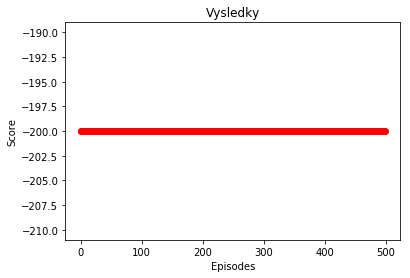

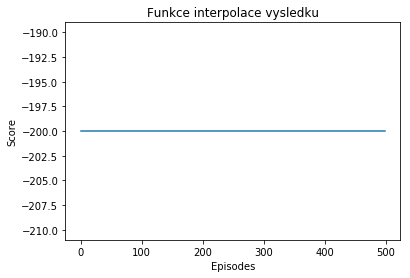

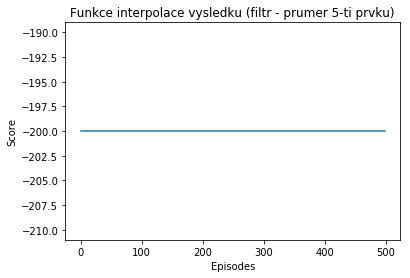

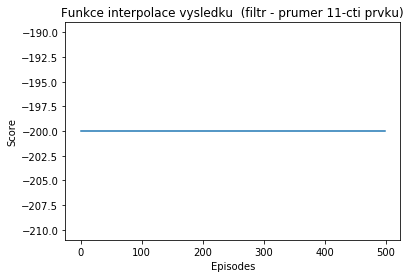

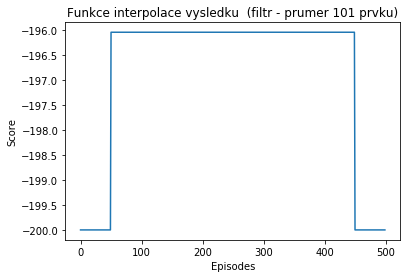

In [8]:
agent.loadNN("./DDQN-MountainCar-v0(1).h5")
observation = env.reset()
scores = []                                # Vycisteni pole pro ulozeni vysledku na analyzu
episodesList = []                          # Vycisteni pole pro ulozeni cisel epizod na analyzu

for g in range (games):
    state = env.reset()
    state = np.reshape(state, [1, stateSize])
    
    totalReward = 0
    done = False
    
    while not done:
        #env.render()
        
        action = agent.getAction(state)
        newState, reward, done, info = env.step(action)

        nextState = np.reshape(newState, [1, stateSize])
        state = nextState

        totalReward += reward
        
    scores.append(totalReward) #ulozeni aktualniho skore
    episodesList.append(g) #ulozeni aktualniho cisla epizody

    print('Game {}/{}, score: {}'.format(g, games, totalReward))

analysis(scores, episodesList)